*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 6 - Learning Best Practices for Model Evaluation and Hyperparameter Tuning

In [53]:
from IPython.display import Image
%matplotlib inline

## Loading the Breast Cancer Wisconsin dataset

In [54]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# if the Breast Cancer dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df = pd.read_csv('wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [55]:
df.shape

(569, 32)

<hr>

In [56]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [57]:
le.transform(['M', 'B'])

array([1, 0])

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

# Fine-tuning machine learning models via grid search

## Tuning hyperparameters via grid search 

In [59]:
# HN: 下面测试 带CV的网格搜索算法。使用带标准化预处理的SVC分类器。可调参数见注释。    

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', # HN: try scoring='recall','precision',‘f1’,'accuracy' to see the best model change
                  refit=True,
                  cv=15,              # HN: try cv=5,10,15 to see the best model change
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print("Best model: ", gs.best_params_)
print("Best score: ",gs.best_score_,"(train performance)")

# use the best model to test data.
clf = gs.best_estimator_
#print('Best score: Test perfrmance: %.3f' % clf.score(X_test, y_test))
print('Best score: ', clf.score(X_test, y_test),"(Test perfrmance)")


Best model:  {'svc__C': 0.1, 'svc__kernel': 'linear'}
Best score:  0.984516129032258 (train performance)
Best score:  0.9736842105263158 (Test perfrmance)


In [71]:
# HN: 下面测试 带CV的随机搜索算法。使用逻辑回归模型，逆正则参数 C 从 (loc, scale)之间均匀抽取     

from scipy.stats import uniform
from sklearn import linear_model, datasets
from sklearn.model_selection import RandomizedSearchCV

# load data
iris = datasets.load_iris()
features = iris.data
target = iris.target

print("  Data shape:",features.shape)
print("Target shape:",target.shape)

# create logistic regression
logistic = linear_model.LogisticRegression(solver='liblinear',max_iter=200) 

# create range of candidate penalty hyper parameter values
penalty = ['l1', 'l2']

# create range of candidate regularizaiton hyperparameter values
C = uniform(loc=0, scale=6)      # HN: try scale=2,4,6,8，to see the best model change

# create dictinoary hyperparameter candidates
hyperparameters = dict(C=C, penalty=penalty)

# create grid search
randomizedsearch = RandomizedSearchCV(estimator=logistic, 
                                      param_distributions=hyperparameters,
                                      random_state=1, n_iter=100, 
                                      scoring='accuracy', # HN: try scoring='recall_micro','precision_micro',‘f1_micro’,'accuracy' to see the best model change
                                      refit=True,
                                      cv=15,               # HN: try cv=5,10,15 to see the best model change
                                      verbose=0, n_jobs=-1)
# fit grid search
best_model = randomizedsearch.fit(features, target)
print("Best model: ", best_model.best_params_)
print("Best score: ",best_model.best_score_, "(train performance)")


  Data shape: (150, 4)
Target shape: (150,)
Best model:  {'C': 5.258334913776229, 'penalty': 'l1'}
Best score:  0.9666666666666668 (train performance)


## Algorithm selection with nested cross-validation

In [61]:
Image(filename='images/06_07.png', width=500) 

FileNotFoundError: [Errno 2] No such file or directory: 'images/06_07.png'

In [78]:
from sklearn.model_selection import cross_val_score
import numpy as np

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=10)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV accuracy: 0.980 +/- 0.021


In [ ]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV accuracy: 0.934 +/- 0.016


# Looking at different performance evaluation metrics

## Reading a confusion matrix

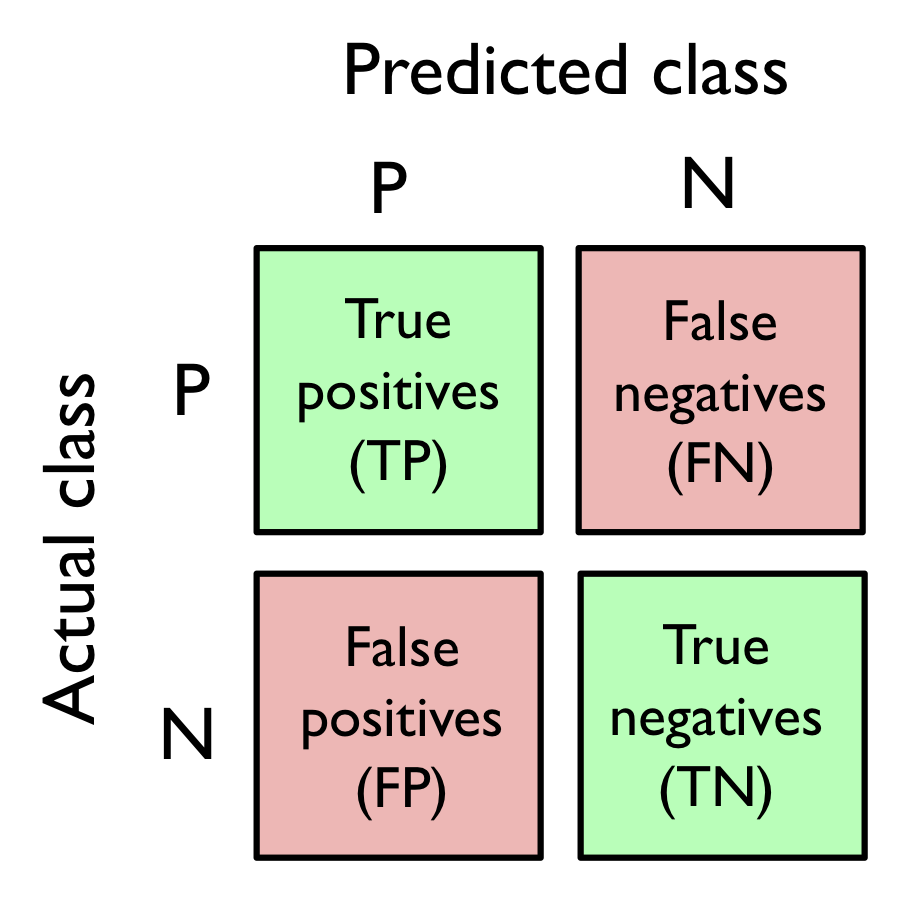

In [ ]:
Image(filename='images/06_08.png', width=300) 

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


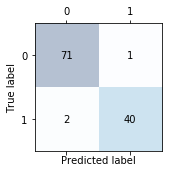

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

### Additional Note

Remember that we previously encoded the class labels so that *malignant* examples are the "postive" class (1), and *benign* examples are the "negative" class (0):

In [ ]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Next, we printed the confusion matrix like so:

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


Note that the (true) class 0 examples that are correctly predicted as class 0 (true negatives) are now in the upper left corner of the matrix (index 0, 0). In order to change the ordering so that the true negatives are in the lower right corner (index 1,1) and the true positves are in the upper left, we can use the `labels` argument like shown below:

In [ ]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[1, 0])
print(confmat)

[[40  2]
 [ 1 71]]


We conclude:

Assuming that class 1 (malignant) is the positive class in this example, our model correctly classified 71 of the examples that belong to class 0 (true negatives) and 40 examples that belong to class 1 (true positives), respectively. However, our model also incorrectly misclassified 1 example from class 0 as class 1 (false positive), and it predicted that 2 examples are benign although it is a malignant tumor (false negatives).

## Optimizing the precision and recall of a classification model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [ ]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=6,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861803938957249
{'svc__C': 0.1, 'svc__kernel': 'linear'}


## Plotting a receiver operating characteristic

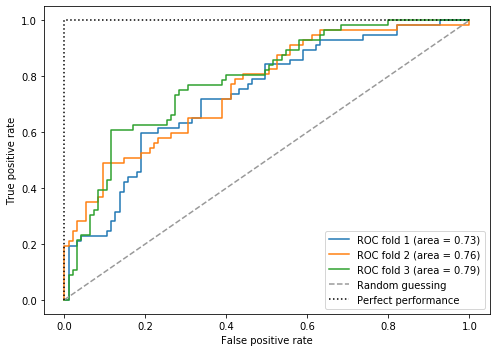

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()